<a href="https://colab.research.google.com/github/ysnarslan/GAN/blob/main/AdvancedGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries

import torch, torchvision, os, PIL, pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def show(tensor, num=25, wandbactive=0, name=''):
    data = tensor.detach().cpu()
    grid = make_grid(data[:num], nrow=5).permute(1, 2, 0)

    if(wandbactive):
        wandb.log({name: wandb.Image(grid.numpy().clip(0, 1))})

    plt.imshow(grid.clip(0, 1))
    plt.show()

In [3]:
# Hyperparameters & General parameters
n_epoch = 100
batch_size = 128
lr = 1e-4
z_dim = 200
device = 'cuda' # GPU

cur_step = 0
crit_cycles = 5
gen_losses = []
crit_losses = []
show_step = 35
save_step = 35
is_wandb = 1 # Track in wandb, optinal (Track: 1, Not track: 0)

In [4]:
## Optional
if is_wandb:
    !pip install wandb -qqq
    import wandb
    wandb.login() # Enter your API key.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
%%capture
if is_wandb:
    experiment_name = wandb.util.generate_id()

    myrun = wandb.init(
        project = 'wgan',
        group = experiment_name,
        config = {
            'optimizer': 'adam',
            'model': 'wgan gp',
            'batch_size': 128,
            'epoch': 1000,
        }
    )

    config = wandb.config

In [6]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, z_dim=64, d_dim=16):
        super(Generator, self).__init__()
        self.z_dim = z_dim

        self.gen = nn.Sequential(
            # inp = 1x1x200 (x_dim) -> out = 4x4x512 (d_dim * 32)
            nn.ConvTranspose2d(in_channels = z_dim,
                               out_channels = d_dim*32,
                               kernel_size = 4,
                               stride = 1,
                               padding = 0),
            nn.BatchNorm2d(d_dim * 32),
            nn.ReLU(inplace=True),

            # 4x4x512 -> 8x8x256
            nn.ConvTranspose2d(in_channels = d_dim*32,
                               out_channels = d_dim*16,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1),
            nn.BatchNorm2d(d_dim * 16),
            nn.ReLU(True),

            # in = 8x8x256 -> out = 16x16x128
            nn.ConvTranspose2d(in_channels = d_dim * 16,
                               out_channels = d_dim * 8,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1),
            nn.BatchNorm2d(d_dim * 8),
            nn.ReLU(True),

            # in = 16x16x128 -> out = 32x32x64
            nn.ConvTranspose2d(in_channels = d_dim * 8,
                               out_channels = d_dim * 4,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1),
            nn.BatchNorm2d(d_dim * 4),
            nn.ReLU(True),

            # in = 32x32x64 -> out = 64x64x32
            nn.ConvTranspose2d(in_channels = d_dim * 4,
                               out_channels = d_dim * 2,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1),
            nn.BatchNorm2d(d_dim * 2),
            nn.ReLU(True),

            # in = 64x64x32 -> out = 128x128x3 (tensor dimension different -> 3x128x128)
            nn.ConvTranspose2d(in_channels = d_dim * 2,
                               out_channels = 3,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1),
            # Produce result in the range from -1 to 1
            nn.Tanh()
        )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1) # 128x200x1x1
        return self.gen(x)

def gen_noise(num, z_dim, device='cuda'):
    return torch.randn(num, z_dim, device=device) # 128x200

In [7]:
# Critic Model
class Critic(nn.Module):
    def __init__(self, d_dim=16):
        super(Critic, self).__init__()

        self.crit = nn.Sequential(
            # conv out = ((n + 2p - k) / stride) + 1
            # in = 3x128x128 -> out = 16x64x64
            nn.Conv2d(in_channels = 3, out_channels = d_dim, kernel_size = 4, stride = 2, padding = 1),
            nn.InstanceNorm2d(d_dim),
            nn.LeakyReLU(0.2),

            # in = 16x64x64 -> out = 32x32x32
            nn.Conv2d(in_channels = d_dim, out_channels = d_dim * 2, kernel_size = 4, stride = 2, padding = 1),
            nn.InstanceNorm2d(d_dim * 2),
            nn.LeakyReLU(0.2),

            # in = 32x32x32 -> out = 64x16x16
            nn.Conv2d(in_channels = d_dim * 2, out_channels = d_dim * 4, kernel_size = 4, stride = 2, padding = 1),
            nn.InstanceNorm2d(d_dim * 4),
            nn.LeakyReLU(0.2),

            # in = 64x16x16 -> out = 128x8x8
            nn.Conv2d(in_channels = d_dim * 4, out_channels = d_dim * 8, kernel_size = 4, stride = 2, padding = 1),
            nn.InstanceNorm2d(d_dim * 8),
            nn.LeakyReLU(0.2),

            # in = 128x8x8 -> out = 256x4x4
            nn.Conv2d(in_channels = d_dim * 8, out_channels = d_dim * 16, kernel_size = 4, stride = 2, padding = 1),
            nn.InstanceNorm2d(d_dim * 16),
            nn.LeakyReLU(0.2),

            # in = 264x4x4 -> out = 1x1x1
            nn.Conv2d(in_channels = d_dim * 16, out_channels = 1, kernel_size = 4, stride = 1, padding = 0),


        )

    def forward(self, image):
        # image: 128x3x128x128
        crit_pred = self.crit(image) # out = 128x1x1x1
        return crit_pred.view(len(crit_pred), -1) # return 128x1

In [8]:
# Optional, init your weights in different ways
def init_weights(m):
    if isinstance(nn.Conv2d) or isinstance(nn.ConvTranspose2d):
        torch.nn.init.normal_(tensor=m.weight, mean=0, std=0.002)
        torch.nn.init.constant_(tensor=m.bias, val=0)

    if isinstance(nn.BatchNorm2d):
        torch.nn.init.normal_(tensor=m.weight, mean=0, std=0.002)
        torch.nn.init.constant_(tensor=m.bias, val=0)

In [11]:
# Load dataset (from Kaggle)

# Make directory name kaggle
! mkdir ~/.kaggle

# Copy the json kaggle to this directory
! cp kaggle.json ~/.kaggle/

# Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

# Download CelebA dataset from Kaggle
!kaggle datasets download -d jessicali9530/celeba-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 1.33G/1.33G [01:05<00:00, 21.1MB/s]
100% 1.33G/1.33G [01:05<00:00, 21.9MB/s]


In [12]:
import zipfile

path = 'data/celeba'
download_path = '/content/celeba-dataset.zip'

if not os.path.exists(path):
    os.makedirs(path)

with zipfile.ZipFile(download_path, 'r') as ziphandler:
    ziphandler.extractall(path)

In [13]:
# Dataset
class Dataset(Dataset):
    def __init__(self, path, size=128, lim=10000):
        self.sizes = [size, size]
        items, labels = [], []

        for data in os.listdir(path)[:lim]:
            item = os.path.join(path, data)
            items.append(item)
            labels.append(data)

        self.items = items
        self.labels = labels

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        data = PIL.Image.open(self.items[idx]).convert('RGB') # size = (x, y)
        data = np.asarray(torchvision.transforms.Resize(self.sizes)(data)) # size = (128, 128)
        data = np.transpose(data, (2, 0, 1)).astype(np.float32, copy=False) # shape 128x128x3 to 3x128x128
        data = torch.from_numpy(data).div(255) # values 0-255 to 0-1
        return data, self.labels[idx]


data_path = '/content/data/celeba/img_align_celeba/img_align_celeba'
ds = Dataset(data_path, size=128, lim=20000)

In [14]:
# DataLoader
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [15]:
# Models
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

# Optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.9))
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.5, 0.9))

# Initializations
# gen = gen.apply(init_weights)
# crit = crit.apply(init_weights)

# wandb optional
if is_wandb == 1:
    wandb.watch(gen, log_freq=100)
    wandb.watch(crit, log_freq=100)


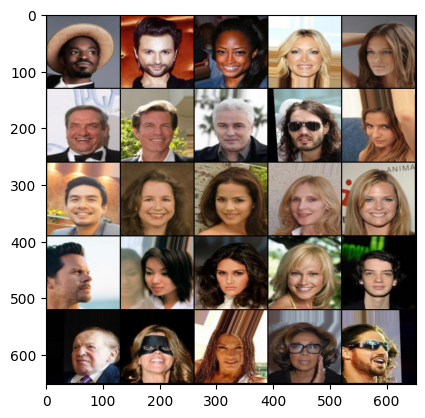

In [16]:
x, y = next(iter(dataloader))
show(x)

In [17]:
#Gradient Penalty
def get_gp(crit, real, fake, alpha, gamma=10):
    mix_images = (alpha * real) + ((1 - alpha) * fake) # 128x3x128x128
    mix_scores = crit(mix_images) # 128x1
    gradient = torch.autograd.grad(inputs=mix_images,
                                   outputs=mix_scores,
                                   grad_outputs = torch.ones_like(mix_scores),
                                   retain_graph=True,
                                   create_graph=True
                                   )[0]  # 128x3x128x128
    gradient = gradient.view(len(gradient), -1) # 128x49152
    gradient_norm = gradient.norm(2, dim=1) # apply dimension 1 - across to dim 0 - L2 reg.
    gp = gamma * ((gradient_norm - 1)**2).mean()

    return gp

In [18]:
# Save and load checkpoints
root_path = './data/'

def save_checkpoint(name):
    torch.save({
        'epoch': epoch,
        'model_state_dict': gen.state_dict(),
        'optimizer_state_dict': gen_opt.state_dict(),
    }, f'{root_path}/G-{name}.pkl')

    torch.save({
        'epoch': epoch,
        'model_state_dict': crit.state_dict(),
        'optimizer_state_dict': crit_opt.state_dict(),
    }, f'{root_path}/C-{name}.pkl')

    print('Saved checkpoint.')

def loaad_checkpoint(name):
    checkpoint = torch.load(f'{root_path}/G-{name}.pkl')
    gen.load_state_dict(checkpoint['model_state_dict'])
    gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

    checkpoint = torch.load(f'{root_path}/C-{name}.pkl')
    crit.load_state_dict(checkpoint['model_state_dict'])
    crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

    print('Checkpoint loaded.')

In [ ]:
# Training loop

for epoch in range(n_epoch):
    for real, _ in tqdm(dataloader):
        cur_bs = len(real) # 128
        real = real.to(device)

        # CRITIC
        mean_crit_loss = 0
        for _ in range(crit_cycles):
            crit_opt.zero_grad()

            noise = gen_noise(cur_bs, z_dim)
            fake = gen(noise)
            crit_fake_pred = crit(fake.detach()) # Do not update generator params
            crit_real_pred = crit(real)

            alpha = torch.randn(cur_bs, 1, 1, 1, device=device, requires_grad=True)
            gp = get_gp(crit, real, fake.detach(), alpha)

            crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp
            mean_crit_loss += crit_loss.item() / crit_cycles

            crit_loss.backward(retain_graph=True)
            crit_opt.step()

        crit_losses += [mean_crit_loss]

        # GENERATOR
        gen_opt.zero_grad()
        noise = gen_noise(cur_bs, z_dim) # return in device
        fake = gen(noise)
        crit_fake_pred = crit(fake)

        gen_loss = -1 * crit_fake_pred.mean()

        gen_loss.backward()
        gen_opt.step()

        gen_losses += [gen_loss.item()]

        # Stats
        if is_wandb:
            wandb.log({'Epoch': epoch, 'Step': cur_step, 'Critic loss': mean_crit_loss, 'Gen loss': gen_loss})

        if cur_step  % save_step == 0 and cur_step > 0:
            print(f'Saving checkpoint: {cur_step} {save_step}')
            save_checkpoint('latest') # latest + epoch/step

        if cur_step % show_step == 0 and cur_step > 0:
            show(fake, wandbactive=1, name='fake')
            show(real, wandbactive=1, name='real')

            gen_mean = sum(gen_losses[-show_step:]) / show_step
            crit_mean = sum(crit_losses[-show_step:]) / show_step

            print(f'Epoch: {epoch} / Step: {cur_step} / Generator loss: {gen_mean} / Crit loss: {crit_mean}')

            plt.plot(
                range(len(gen_losses)),
                torch.Tensor(gen_losses),
                label='Generator Loss',
            )
            plt.plot(
                range(len(crit_losses)),
                torch.Tensor(crit_losses),
                label='Critic Loss',
            )

            plt.ylim(-100, 100)
            plt.legend()
            plt.show()

        cur_step += 1